In [283]:
#!pip install tf-nightly-2.0-preview

In [284]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Import the function
sys.path.append(os.path.abspath('../src/data'))
from extract_for_model_new import extract_time_series
from extract_for_model_new import scale_time_series

"""
 -------------------------------
 extract_time_series
 -------------------------------

 Function takes the data in interim format from /reference/data_interim
 and returns the time-series as a supervised learning problem.
 Refer to: 
 https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
 
 
 Input :
 input_path (string) = path to the data set in INTERIM format
 features   (list)   = list of features to be extracted from the dataset
 ids        (list)   = optional list of company_IDs to be considered
 year_min   (int)    = cut-off, dates prior to that will be discarded
 steps      (int)    = how many years back should be treated as independent variables

 Output:
 time_series_df (dataframe) = dataframe with processed time-series data   

"""

In [285]:
# Example 1: 1 Feature, 3 Comapnies, 2 steps
# 
input_path = '/home/reference/data_interim/software_private_annual_income_statements_INTERIM.csv'
# Data combined from Peri file and my study
#features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
#              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
#              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
features = ['IQ_TOTAL_OTHER_OPER', 'IQ_EBIT',  'IQ_TOTAL_REV']
ids        = []
year_min   = 2014
steps      = -1
unitshift = 0
train_df, test_df = extract_time_series(input_path = input_path,
                                   features = features,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
#train_df.head(), 
#print(test_df)

train_df_scale,test_df_scale = scale_time_series(train_df, test_df,['company'],features,'standard')



Size BEFORE dropping NA: (1286, 6)
Size AFTER dropping NA: (1274, 6)
TEST  set size: (276, 6)
TRAIN set size: (998, 6)
TEST is 22% of all available datapoints


In [286]:
from scipy import stats
def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

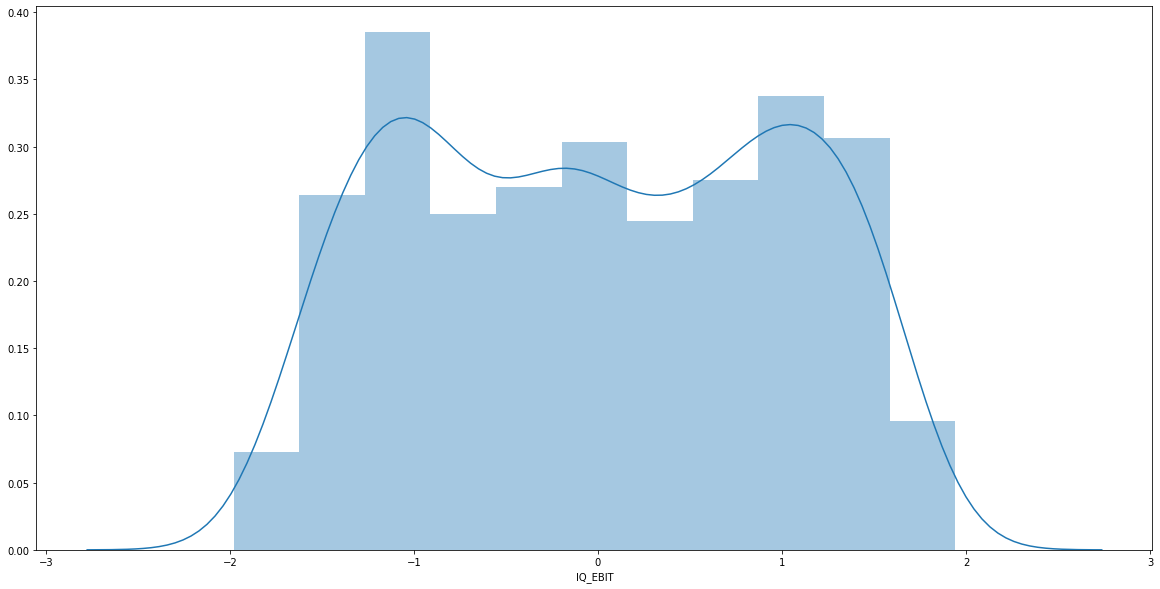

In [287]:
plt.figure(figsize = (20,10))
sns.distplot(train_df_scale['IQ_EBIT'])

In [288]:
plt.figure(figsize = (20,10))
sns.distplot(train_df_scale['IQ_OPER_INC'])

KeyError: 'IQ_OPER_INC'

<Figure size 1440x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (20,10))
sns.distplot(train_df_scale['IQ_TOTAL_REV'])

In [ ]:
plt.figure(figsize = (20,10))
sns.distplot(train_df_scale['IQ_TOTAL_OTHER_OPER'])

In [ ]:
sns.pairplot(train_df)

In [ ]:
sns.pairplot(train_df_scale)

In [ ]:
#print(type(train_df_scale))
dataset = pd.concat([train_df_scale,test_df_scale])
dataset.drop(['year','quarter'],axis = 1,inplace = True)

In [ ]:
print(type(dataset))
dataset.head()

In [ ]:
# Drop the outliers
drop_numerical_outliers(dataset)

In [ ]:
# Cluster the data using the 4 variables
# Calulate the inertia and the silhouette score 
# Silhouette score : Cohesion (how close points in a cluster are relative to each other) 
# Silhouette score :  Separation (how far the clusters are relative to each other).
# changing the number of clusters
from sklearn.metrics import silhouette_samples, silhouette_score


inertia = [] # List of the inertia score for each cluster and plot the elbow curve(a measure of how internally coherent clusters are.)
sil = [] # List the silhouette score
X = dataset.loc[:,'IQ_TOTAL_OTHER_OPER':]
for i in range(2,11):
    #plt.figure(figsize=(6, 6))
    
    # Predicting the clusters
    
    y_pred = KMeans(n_clusters=i,random_state = 0)
    y_pred.fit(X)
    cluster_label = y_pred.predict(X)
    inertia.append([i,y_pred.inertia_])
    sil.append((i, silhouette_score(X, cluster_label)))
    


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')


# Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

In [ ]:
# We retain 5 clusters due to inertia and the silhouette curve
y_pred = KMeans(n_clusters=3, random_state = 7)
y_pred.fit(X)
cluster_label = y_pred.predict(X)
centroid = y_pred.cluster_centers_

In [ ]:
len(cluster_label[cluster_label==0])

In [ ]:
len(cluster_label[cluster_label==2])

In [ ]:
centroid

## We make new changes:
    Drop IQ_OPER_INC
    Drop IQ_EBITDA
    Add the others from this list
    features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP',
              'IQ_OPER_INC','IQ_EBITDA','IQ_EARNING_CO','IQ_OTHER_OPER',
             'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']    

In [ ]:
# Example 1: 1
# 
input_path = '/home/reference/data_interim/software_private_annual_income_statements_INTERIM.csv'
# Data combined from Peri file and my study
features   = [ 'IQ_TOTAL_OTHER_OPER','IQ_NI','IQ_GP','IQ_EBIT',
              'IQ_EARNING_CO','IQ_OTHER_OPER',
              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
#features = ['IQ_TOTAL_OTHER_OPER', 'IQ_EBIT', 'IQ_OPER_INC', 'IQ_TOTAL_REV']
ids        = []
year_min   = 2014
steps      = -1
unitshift = 0
train_df, test_df = extract_time_series(input_path = input_path,
                                   features = features,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
#train_df.head(), 
#print(test_df)

train_df_scale_new,test_df_scale_new = scale_time_series(train_df, test_df,['company'],features,'standard')



In [ ]:
# Combine the train and test set data
dataset_new = pd.concat([train_df_scale_new,test_df_scale_new])
dataset_new.drop(['year','quarter'],axis = 1,inplace = True)

In [ ]:
dataset_new.head()


In [ ]:
sns.pairplot(train_df)

In [ ]:
sns.pairplot(train_df[['IQ_OTHER_OPER','IQ_NI','IQ_EBIT','IQ_EARNING_CO',
              'IQ_TOTAL_REV']])

In [ ]:
pearsoncorr =train_df.corr()
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

## I eliminate:
    IQ_GP because it is strongly correlated to IQ_TOTAL_REV
    IQ_TOTAL_OTHER_OPER because it is strongly to IQ_OTHER_OPER is less correlated to the others
    IQ_OPER_INC is also eliminated because it is strongly correlated to IQ_EBIT
## I choose one between IQ_NI, IQ_EBIT and IQ_EARNING_CO and I choose IQ_EBIT


In [ ]:
# Example 3
# 
input_path = '/home/reference/data_interim/software_private_annual_income_statements_INTERIM.csv'
# Data combined from Peri file and my study
features   = [ 'IQ_EBIT',
              'IQ_OTHER_OPER',
              'IQ_INC_TAX','IQ_NET_INTEREST_EXP','IQ_TOTAL_REV']
#IQ_AR (accounts receivable); IQ_RE (retained earnings); 
#IQ_TOTAL_ASSETS; IQ_TOTAL_CA (total current assets);
#IQ_TOTAL_LIAB_EQUITY (total liability equity)
#features = ['IQ_EARNING_CO','IQ_TOTAL_REV','IQ_OTHER_OPER','IQ_EBIT','IQ_OPER_INC']
#features = ['IQ_TOTAL_OTHER_OPER', 'IQ_EBIT', 'IQ_OPER_INC', 'IQ_TOTAL_REV']
ids        = []
year_min   = 2014
steps      = -1
unitshift = 0
train_choosen_df, test_choosen_df = extract_time_series(input_path = input_path,
                                   features = features,
                                    
                                      steps = steps,
                                 unitshift = 0
                                 
                                
                                )
#train_df.head(), 
#print(test_df)

train_df_scale_choosen,test_df_scale_choosen = scale_time_series(train_choosen_df, test_choosen_df,['company'],features,'minmax')



In [ ]:
# Example 1: 1
# 
#input_path = '/home/reference/data_interim/software_private_annual_balance_sheets_INTERIM.csv'
# Data combined from Peri file and my study
#features2   = [ 'IQ_AR','IQ_RE','IQ_TOTAL_ASSETS','IQ_TOTAL_CA','IQ_TOTAL_LIAB_EQUITY']
#features = ['IQ_TOTAL_OTHER_OPER', 'IQ_EBIT', 'IQ_OPER_INC', 'IQ_TOTAL_REV']
#ids        = []
#year_min   = 2012
#steps      = -1
#unitshift = 0
#train_bal_df, test_bal_df = extract_time_series(input_path = input_path,
#                                   features = features2,
                                    
#                                      steps = steps,
#                                 unitshift = 0
                                 
                               
#                                  )
#train_df.head(), 
#print(test_df)

#train_bal_df_scale_new,test_bal_df_scale_new = scale_time_series(train_bal_df, test_bal_df,['company'],features2,'standard')



In [ ]:
dataset_choosen = pd.concat([train_choosen_df, test_choosen_df])
dataset_scale_choosen = pd.concat([train_df_scale_choosen, test_df_scale_choosen])

In [ ]:
sns.pairplot(dataset_choosen)

In [ ]:
sns.pairplot(dataset_scale_choosen)

In [ ]:
dataset_scale_choosen.head()

In [ ]:
# Drop the outliers
drop_numerical_outliers(dataset_scale_choosen)

In [ ]:
dataset_scale_choosen.drop(['year','quarter'],axis = 1,inplace = True)

In [ ]:
# Cluster the data using the 4 variables
# Calulate the inertia and the silhouette score 
# Silhouette score : Cohesion (how close points in a cluster are relative to each other) 
# Silhouette score :  Separation (how far the clusters are relative to each other).
# changing the number of clusters
from sklearn.metrics import silhouette_samples, silhouette_score


inertia = [] # List of the inertia score for each cluster and plot the elbow curve(a measure of how internally coherent clusters are.)
sil = [] # List the silhouette score
X = dataset_choosen.loc[:,'IQ_EBIT':]
for i in range(2,11):
    #plt.figure(figsize=(6, 6))
    
    # Predicting the clusters
    
    y_pred = KMeans(n_clusters=i, random_state = 2)
    y_pred.fit(X)
    cluster_label = y_pred.predict(X)
    inertia.append([i,y_pred.inertia_])
    sil.append((i, silhouette_score(X, cluster_label)))
    #print(type(cluster_label))
    


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')


# Plotting Silhouetter Score
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

In [ ]:
# We retain 4 clusters due to inertia and the silhouette curve
y_pred = KMeans(n_clusters=4, random_state = 7)
y_pred.fit(X)
cluster_label = y_pred.predict(X)


In [ ]:
for i in range(4):
    print(i,len(cluster_label[cluster_label==i]))

In [ ]:
centroids = y_pred.cluster_centers_

In [ ]:
centroids

In [ ]:
# Get the clusters for each row
clusters  = pd.Series(y_pred.labels_)
dataset_choosen = dataset_choosen.assign(centroids=clusters.values)

In [ ]:
#Add a new column to the dataframe defining the cluster for each row
dataset_choosen.head()

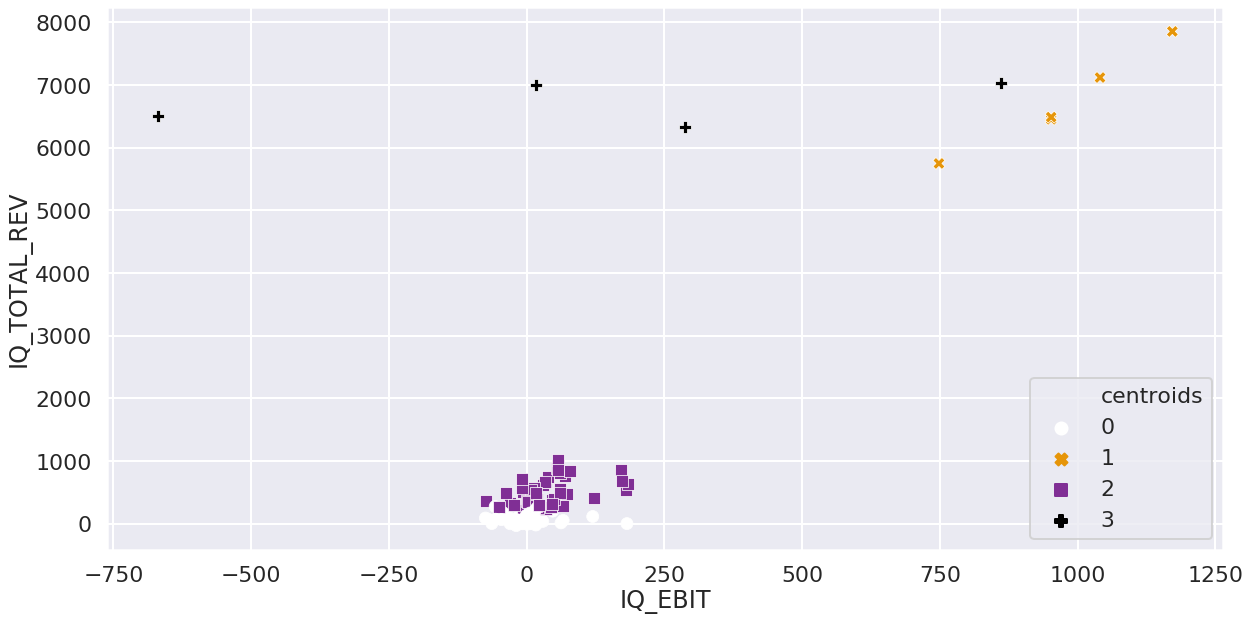

In [317]:
sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="IQ_EBIT", y="IQ_TOTAL_REV", hue="centroids",style = "centroids",palette =  "CMRmap_r",data = dataset_choosen)

# Provide a dictionary to the palette argument
#ax = sns.scatterplot( x="IQ_EBIT", y="IQ_TOTAL_REV", data=dataset_choosen, fit_reg=False , hue = "centroids" , legend=False, palette=dict(0="#9b59b6", 1="#3498db", 2="#95a5a6" 3 = "#96a5B6"))
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
 
#sns.plt.show()
